# Tests de Models Unet

### Imports

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold

# KERAS
from tensorflow.keras import models, layers, utils, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [204]:
#Project Files
from canopywatch.ml_logic.preprocessor import image_preprocessing, image_preprocessing_bulk
from canopywatch.ml_logic.registry import save_model

## Load images et preprocess

In [205]:
data_path = '../data/Forest Segmented/meta_data.csv'
data = pd.read_csv(data_path)

In [206]:
img_path = '../data/Forest Segmented/images'
masks_path = '../data/Forest Segmented/masks'

In [207]:
# Load and order filenames
image_filepath = sorted([os.path.join(img_path, f) for f in os.listdir(img_path) if f.endswith('.jpg')])
mask_filepath = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.jpg')])

In [208]:
# Faire le image_preprocessing sur toutes les images: (Potentiellement pb de RAM)
# images_processed = image_preprocessing_bulk(image_filepath)
images_processed = []

for i in range(0,501):
    image_preprocessed = image_preprocessing(image_filepath[i])
    images_processed.append(image_preprocessed)


In [209]:
#500 masks
masks_pr = []

for i in range(0,501):
    image_preprocessed = image_preprocessing(mask_filepath[i])
    masks_pr.append(image_preprocessed)


In [210]:
X = images_processed
y = masks_pr

In [211]:
X = np.stack(X)
y = np.stack(y)

In [212]:
y = y[:,:,:,2:]

#### Essai tensorflow load

In [213]:
train_ds = utils.image_dataset_from_directory('../data/Forest Segmented/', labels='inferred')

Found 10218 files belonging to 4 classes.


In [214]:
class_names = train_ds.class_names
print(class_names)
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

['images', 'images_out_context', 'masks', 'models_test_info']
(32, 256, 256, 3)
(32,)


In [215]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [216]:
# len(normalized_ds)

#### Verif visuelle de 10 random images


In [217]:
# #Verif visuelle de 10 random images
# fig = plt.figure(figsize=(10, 10))
# count  = 0
# for i in np.random.randint(200, size=10):
#     # Display image
#     image_filename = data.iloc[i]['image']
#     mask_filename = data.iloc[i]['mask']

#     plt.subplot(10, 2, 2*count + 1)
#     # img = image_preprocessing(f'{img_path}/{image_filename}')
#     plt.imshow(images_processed[i])
#     plt.title(image_filename)
#     plt.xticks(())
#     plt.yticks(())

#     # Display corresponding mask
#     plt.subplot(10, 2, 2*count + 2)
#     mask = image_preprocessing(f'{masks_path}/{mask_filename}')
#     plt.imshow(masks_pr[i])
#     plt.title(mask_filename)
#     plt.xticks(())
#     plt.yticks(())
#     count+=1


# plt.tight_layout()
# plt.show()

## Debut des Tests

In [218]:
#Split our data for tests 80:20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Building Unet functions : 

In [219]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [220]:
def triple_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [221]:
def quintuple_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [222]:
def triple_conv_block3D(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv3D(filters=8, kernel_size=(5, 5, 5), strides=(2, 2, 2), padding='same', input_shape=(28, 28, 28, 1))(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [223]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.4)(p)
   return f, p

In [224]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.4)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

### Assembler l'Unet et faire le compiler : 

In [225]:
def build_unet_model():
    inputs = layers.Input((256,256,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = triple_conv_block(p2, 256)
    # 4 - downsample
    f4, p4 = triple_conv_block(p3, 512)
    # 5 - bottleneck
    bottleneck = triple_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = triple_conv_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = triple_conv_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(filter=1, kernel_size=3, strides=(2,2), padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = Model([inputs], [outputs], name="U-Net")
    return unet_model

In [226]:
def build_unet_model():
    inputs = layers.Input((256,256,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 8)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 16)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 32)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 64)
    # 5 - bottleneck
    bottleneck = triple_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 16)
    # 9 - upsample
    #u9 = layers.Conv2D(2**6, 1, activation = 'sigmoid', padding = 'same')(u8) # tester
    u9 = upsample_block(u8, f1, 8)
    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = Model([inputs], [outputs], name="U-Net")
    return unet_model

In [227]:
optimizer = Adam()


In [228]:
def model_compile(model):
    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics="accuracy")
    return model

In [229]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 256, 256, 8)  224         ['input_5[0][0]']                
                                                                                                  
 conv2d_85 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_84[0][0]']              
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 128, 128, 8)  0          ['conv2d_85[0][0]']          

In [230]:
unet_model_compiled = model_compile(unet_model)

### Fit the model :

In [231]:
es = EarlyStopping(patience=3, restore_best_weights = True)

history = unet_model_compiled.fit(X_train, y_train, epochs=100, callbacks = [es])


Epoch 1/100
10/10 [==============================] - 144s 14s/step - loss: 0.9932 - accuracy: 0.4136
Epoch 2/100
10/10 [==============================] - 143s 14s/step - loss: 0.6941 - accuracy: 0.5091
Epoch 3/100
10/10 [==============================] - 143s 14s/step - loss: 0.6917 - accuracy: 0.5665
Epoch 4/100
10/10 [==============================] - 144s 14s/step - loss: 0.6902 - accuracy: 0.5955
Epoch 5/100
10/10 [==============================] - 143s 14s/step - loss: 0.6891 - accuracy: 0.6073
Epoch 6/100
10/10 [==============================] - 143s 14s/step - loss: 0.6881 - accuracy: 0.6131
Epoch 7/100
10/10 [==============================] - 143s 14s/step - loss: 0.6869 - accuracy: 0.6175
Epoch 8/100
10/10 [==============================] - 143s 14s/step - loss: 0.6855 - accuracy: 0.6190
Epoch 9/100
10/10 [==============================] - 143s 14s/step - loss: 0.6823 - accuracy: 0.6205
Epoch 10/100
10/10 [==============================] - 143s 14s/step - loss: 0.6779 - accura

In [232]:
save_model(unet_model_compiled)

✅ Model saved locally
❌ Model NOT saved to GCS


In [233]:
# Features File Generator

## Extract model Weights
weights = unet_model_compiled.get_weights()

In [234]:
## Print Weights
from tabulate import tabulate

headers = ["N°", "Weight Shape", "Type of Data"]

table = []

for i, weight in enumerate(weights):
    table.append([
        i,
        str(weight.shape),
        str(weight.dtype)
    ])

print(tabulate(table, headers, tablefmt='mixed_outline'))

┍━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━┑
│   N° │ Weight Shape       │ Type of Data   │
┝━━━━━━┿━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━┥
│    0 │ (3, 3, 3, 8)       │ float32        │
│    1 │ (8,)               │ float32        │
│    2 │ (3, 3, 8, 8)       │ float32        │
│    3 │ (8,)               │ float32        │
│    4 │ (3, 3, 8, 16)      │ float32        │
│    5 │ (16,)              │ float32        │
│    6 │ (3, 3, 16, 16)     │ float32        │
│    7 │ (16,)              │ float32        │
│    8 │ (3, 3, 16, 32)     │ float32        │
│    9 │ (32,)              │ float32        │
│   10 │ (3, 3, 32, 32)     │ float32        │
│   11 │ (32,)              │ float32        │
│   12 │ (3, 3, 32, 64)     │ float32        │
│   13 │ (64,)              │ float32        │
│   14 │ (3, 3, 64, 64)     │ float32        │
│   15 │ (64,)              │ float32        │
│   16 │ (3, 3, 64, 1024)   │ float32        │
│   17 │ (1024,)            │ float32        │
│   18 │ (3, 

In [235]:
weights

[array([[[[ 3.07378083e-01,  9.31881294e-02, -1.19804427e-01,
            3.15048367e-01,  3.19717854e-01, -4.80809718e-01,
            1.31497696e-01,  4.91908222e-01],
          [ 3.61082852e-02, -2.19500378e-01,  7.78768286e-02,
            2.99341798e-01, -4.96864207e-02,  1.20293111e-01,
           -7.81672001e-02, -2.19340816e-01],
          [ 3.00326973e-01, -4.82400530e-04,  4.42838222e-02,
           -2.89412234e-02,  3.49805683e-01,  2.68350132e-02,
           -3.64729404e-01,  3.71875390e-02]],
 
         [[-1.66109994e-01,  1.41468346e-01,  4.45783347e-01,
            2.14126736e-01,  1.56439468e-01, -2.08848625e-01,
           -5.71820796e-01, -3.96164179e-01],
          [ 3.10375065e-01,  3.01292896e-01,  2.91912928e-02,
           -3.64222020e-01,  9.33618546e-02, -3.50668967e-01,
           -1.54286832e-01, -1.58825386e-02],
          [-1.49298444e-01, -3.18740875e-01, -1.40403256e-01,
           -1.15948051e-01,  5.87513506e-01,  4.14206460e-02,
            2.07152814e

In [236]:
len(X_train)

320

In [237]:
jeanmich = np.expand_dims(X_test[56],axis=0)

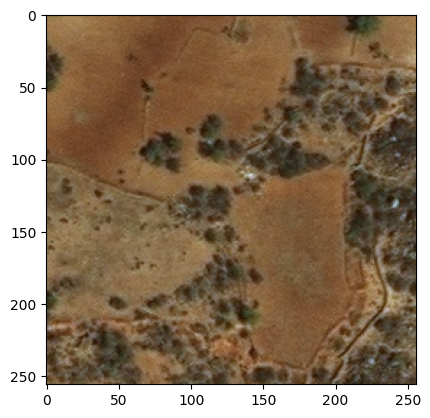

In [238]:
plt.imshow(jeanmich[0])

1/1 [==============================] - 0s 419ms/step


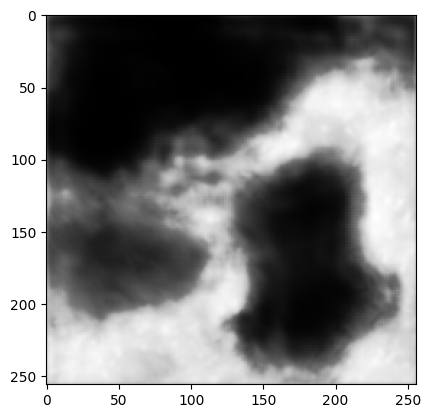

In [239]:
plt.imshow(unet_model_compiled.predict(jeanmich)[0], cmap='gray')

In [240]:
jeanpich = np.expand_dims(X_val[47],axis=0)

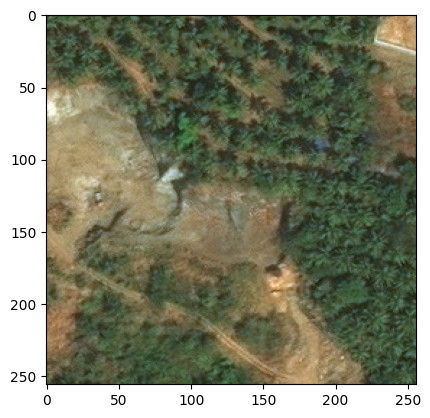

In [241]:
plt.imshow(jeanpich[0])

1/1 [==============================] - 0s 147ms/step


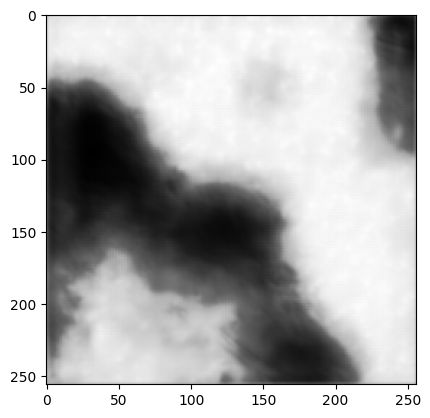

In [242]:
plt.imshow(unet_model_compiled.predict(jeanpich)[0], cmap='gray')

In [243]:
W_test = '../data/Forest Segmented/images_out_context/test_img_out_256_01.png'
W_test_preprocessed = image_preprocessing(W_test)
W_test_preprocessed_exp = np.expand_dims(W_test_preprocessed,axis=0)

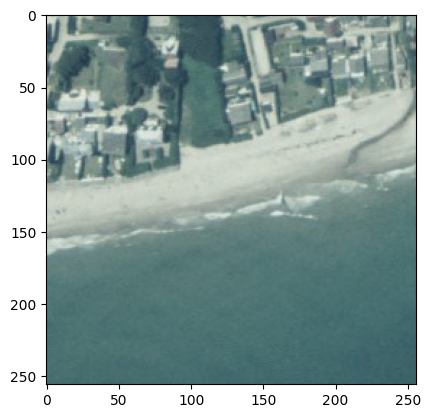

In [244]:
plt.imshow(W_test_preprocessed_exp[0])

1/1 [==============================] - 0s 142ms/step


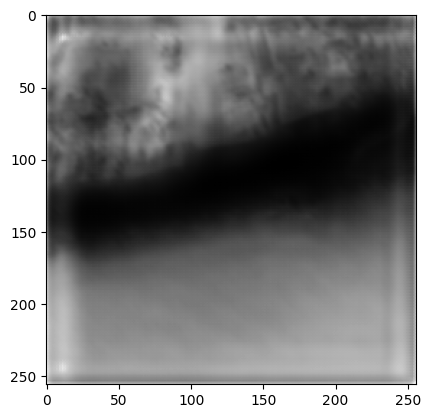

In [245]:
plt.imshow(unet_model_compiled.predict(W_test_preprocessed_exp)[0], cmap='gray')

In [246]:
W_test2 = '../data/Forest Segmented/images_out_context/test_img_out_256_02.png'
W_test_preprocessed2 = image_preprocessing(W_test2)
W_test_preprocessed_exp2 = np.expand_dims(W_test_preprocessed2,axis=0)

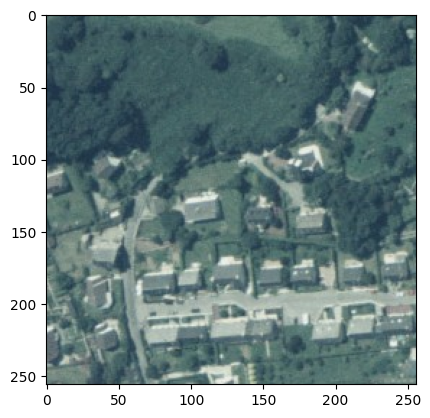

In [247]:
plt.imshow(W_test_preprocessed_exp2[0])

In [248]:
plt.imshow(unet_model_compiled.predict(W_test_preprocessed_exp2)[0], cmap='gray')

2024-12-03 03:49:17.814724: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:719 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3


InvalidArgumentError: Graph execution error:

Detected at node 'U-Net/conv2d_84/Relu' defined at (most recent call last):
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_6039/4001817235.py", line 1, in <module>
      plt.imshow(unet_model_compiled.predict(W_test_preprocessed_exp2)[0], cmap='gray')
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/blackteukbeu/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/keras/backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'U-Net/conv2d_84/Relu'
input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node U-Net/conv2d_84/Relu}}]] [Op:__inference_predict_function_27552]